In [123]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
import tensorflow as tf

In [124]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Basic RNN
illustrates a layer of 5 recurrent neurons 

![LayerOfReuron.png](attachment:LayerOfReuron.png)

In [125]:
import time
d = np.int32(time.time())
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

input of four instances:
Each instance represents a sampled random process

In [126]:
import numpy as np

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val_, Y1_val_ = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [127]:
Y0_val_
#np.sum(Y0_val-Y0_val_,axis=0)

array([[-0.0664006 ,  0.9625767 ,  0.68105793,  0.7091854 , -0.898216  ],
       [ 0.9977755 , -0.719789  , -0.9965761 ,  0.9673924 , -0.9998972 ],
       [ 0.99999774, -0.99898803, -0.9999989 ,  0.9967762 , -0.9999999 ],
       [ 1.        , -1.        , -1.        , -0.99818915,  0.9995087 ]],
      dtype=float32)

In [128]:
Y1_val_
#Y1_val-Y1_val_

array([[ 1.        , -1.        , -1.        ,  0.4020025 , -0.9999998 ],
       [-0.12210421,  0.6280527 ,  0.9671843 , -0.9937122 , -0.25839362],
       [ 0.9999983 , -0.9999994 , -0.9999975 , -0.8594331 , -0.9999881 ],
       [ 0.99928284, -0.99999815, -0.9999058 ,  0.9857963 , -0.92205757]],
      dtype=float32)

# Using static_rnn()
run with fixed time steps

In [129]:
n_inputs = 3
n_neurons = 5
reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1],
                                                dtype=tf.float32)
Y0, Y1 = output_seqs

In [130]:
init = tf.global_variables_initializer()
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1
with tf.Session() as sess:
    init.run()
    X1_size=X1.eval(feed_dict={X0: X0_batch, X1: X1_batch}).shape
    [Y0_valS, Y1_valS] = sess.run([Y0,Y1], feed_dict={X0: X0_batch, X1: X1_batch})
    pass

In [131]:
print(X1_size)
Y0_valS

(4, 3)


array([[ 0.30741334, -0.32884315, -0.6542847 , -0.9385059 ,  0.52089024],
       [ 0.99122757, -0.9542542 , -0.7518079 , -0.9995208 ,  0.9820235 ],
       [ 0.9999268 , -0.99783254, -0.8247353 , -0.9999963 ,  0.99947774],
       [ 0.996771  , -0.68750614,  0.8419969 ,  0.9303911 ,  0.8120684 ]],
      dtype=float32)

In [132]:
Y1_valS

array([[ 0.99998885, -0.9997605 , -0.06679298, -0.9999804 ,  0.99982214],
       [-0.6524944 , -0.51520866, -0.37968954, -0.59225935, -0.08968385],
       [ 0.998624  , -0.997152  , -0.03308626, -0.9991565 ,  0.9932902 ],
       [ 0.99681675, -0.9598194 ,  0.39660636, -0.8307605 ,  0.7967197 ]],
      dtype=float32)

In [133]:
#show_graph(tf.get_default_graph())

# Static rnn () extension - Packing sequences
run pre-programmable time steps <br>
States is the last step of output

In [134]:
n_steps = 3
n_inputs = 3
n_neurons = 5
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs,
                                                dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

In [135]:
init = tf.global_variables_initializer()
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7],[1,2,3]], # instance 1
        [[3, 4, 5], [0, 0, 0],[1,2,3]], # instance 2
        [[6, 7, 8], [6, 5, 4],[1,2,3]], # instance 3
        [[9, 0, 1], [3, 2, 1],[1,2,3]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})
    outputs_val, states_val = sess.run([outputs, states],  feed_dict={X: X_batch})

In [136]:
np.shape(outputs_val)

(4, 3, 5)

In [137]:
np.shape(states_val)

(4, 5)

In [138]:
states_val

array([[-0.9135523 , -0.88120127,  0.8607582 ,  0.9710674 , -0.9747271 ],
       [-0.8063481 , -0.9394014 ,  0.6785674 ,  0.9490792 , -0.96972144],
       [-0.9087715 , -0.8799446 ,  0.8602572 ,  0.96978194, -0.97464114],
       [-0.88796663, -0.9282189 ,  0.8787439 ,  0.9757828 , -0.94433916]],
      dtype=float32)

In [139]:
outputs_val

array([[[-0.45652324, -0.68064123,  0.40938237,  0.63104504,
         -0.45732826],
        [-0.94288003, -0.9998869 ,  0.94055814,  0.9999985 ,
         -0.9999997 ],
        [-0.9135523 , -0.88120127,  0.8607582 ,  0.9710674 ,
         -0.9747271 ]],

       [[-0.8001535 , -0.9921827 ,  0.7817797 ,  0.9971031 ,
         -0.9964609 ],
        [-0.637116  ,  0.11300932,  0.5798437 ,  0.43105593,
         -0.63716984],
        [-0.8063481 , -0.9394014 ,  0.6785674 ,  0.9490792 ,
         -0.96972144]],

       [[-0.93605185, -0.9998379 ,  0.9308867 ,  0.9999815 ,
         -0.99998295],
        [-0.9165386 , -0.9945604 ,  0.89605415,  0.99987197,
         -0.9999751 ],
        [-0.9087715 , -0.8799446 ,  0.8602572 ,  0.96978194,
         -0.97464114]],

       [[ 0.9927369 , -0.9981933 , -0.55543643,  0.9989031 ,
         -0.9953323 ],
        [-0.02746334, -0.73191994,  0.7827872 ,  0.9525682 ,
         -0.97817713],
        [-0.88796663, -0.9282189 ,  0.8787439 ,  0.9757828 ,
         

As seen, the graph hard code all unrolled neuron layers

In [140]:
show_graph(tf.get_default_graph())

# Using dynamic_rnn()

In [141]:
n_steps = 3
n_inputs = 3
n_neurons = 5
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,swap_memory=True)

In [142]:
init = tf.global_variables_initializer()
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7],[1,2,3]], # instance 1
        [[3, 4, 5], [0, 0, 0],[0,0,0]], # instance 2
        [[6, 7, 8], [6, 5, 4],[1,2,3]], # instance 3
        [[9, 0, 1], [3, 2, 1],[1,2,3]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [143]:
outputs_val

array([[[-0.46430176, -0.04473137,  0.45657092, -0.601556  ,
         -0.28795418],
        [-0.9999999 , -0.9713097 ,  0.9993345 , -0.6387589 ,
         -0.90433717],
        [-0.6874611 , -0.27588975,  0.9234373 , -0.5954472 ,
         -0.8916085 ]],

       [[-0.9983903 , -0.71462387,  0.9559315 , -0.86314553,
         -0.68196076],
        [ 0.5243204 ,  0.32354677,  0.5477097 ,  0.3201615 ,
         -0.60165435],
        [ 0.1560038 , -0.03623265, -0.40326107,  0.42590767,
         -0.4787026 ]],

       [[-0.99999654, -0.94119084,  0.9972825 , -0.95754653,
         -0.8785113 ],
        [-0.99987805, -0.8886723 ,  0.995402  , -0.22945826,
         -0.9196897 ],
        [-0.77057207, -0.45098898,  0.90543187, -0.6137094 ,
         -0.91868967]],

       [[-0.99997157, -0.75314504,  0.73893744, -0.9392927 ,
          0.46864882],
        [-0.96881694, -0.10343015,  0.84094274, -0.09726937,
         -0.28027278],
        [-0.9180945 , -0.07748092,  0.83017296, -0.4773658 ,
         

In [144]:
show_graph(tf.get_default_graph())

# Setting variable sequence length

In [145]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length,swap_memory=True)

In [146]:
init = tf.global_variables_initializer()
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5],[0,0,0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [147]:
outputs_val

array([[[ 0.65519077, -0.38949275, -0.6105231 ,  0.5927638 ,
         -0.48083815],
        [ 0.9999941 ,  0.99594396,  0.4582593 ,  0.9991697 ,
          0.8991136 ]],

       [[ 0.9978262 ,  0.44117272, -0.5916074 ,  0.9749958 ,
         -0.35678416],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ]],

       [[ 0.9999887 ,  0.87606186, -0.5720173 ,  0.99874693,
         -0.21872665],
        [ 0.9995612 ,  0.9808731 ,  0.8890911 ,  0.9768431 ,
          0.5203418 ]],

       [[ 0.9990465 ,  0.92710733,  0.23267001,  0.9804318 ,
          0.99994713],
        [ 0.9791339 ,  0.719474  ,  0.93568635,  0.63649696,
         -0.17854698]]], dtype=float32)

In [148]:
states_val #contain the final state of output_val

array([[ 0.9999941 ,  0.99594396,  0.4582593 ,  0.9991697 ,  0.8991136 ],
       [ 0.9978262 ,  0.44117272, -0.5916074 ,  0.9749958 , -0.35678416],
       [ 0.9995612 ,  0.9808731 ,  0.8890911 ,  0.9768431 ,  0.5203418 ],
       [ 0.9791339 ,  0.719474  ,  0.93568635,  0.63649696, -0.17854698]],
      dtype=float32)

In [149]:
outputs_val[:,-1,:]

array([[ 0.9999941 ,  0.99594396,  0.4582593 ,  0.9991697 ,  0.8991136 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.9995612 ,  0.9808731 ,  0.8890911 ,  0.9768431 ,  0.5203418 ],
       [ 0.9791339 ,  0.719474  ,  0.93568635,  0.63649696, -0.17854698]],
      dtype=float32)

# Training a sequence classifier
Note: the book uses tensorflow.contrib.layers.fully_connected() rather than tf.layers.dense() (which did not exist when this chapter was written). It is now preferable to use tf.layers.dense(), because anything in the contrib module may change or be deleted without notice. The dense() function is almost identical to the fully_connected() function. The main differences relevant to this chapter are:

several parameters are renamed: scope becomes name, activation_fn becomes activation (and similarly the _fn suffix is removed from other parameters such as normalizer_fn), weights_initializer becomes kernel_initializer, etc.
the default activation is now None rather than tf.nn.relu.

In [150]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

with tf.name_scope("rnn"):
  basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
  outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
  logits = tf.layers.dense(states, n_outputs)

with tf.name_scope("loss"):
  xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
  loss = tf.reduce_mean(xentropy)
with tf.name_scope("train"):
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
  correct = tf.nn.in_top_k(logits, y, 1)
  accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [151]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [152]:
def training_identifier_RNN(sess,n_epochs,saver):
  for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        
        acc_test_str = acc_summary.eval(feed_dict={accuracy:acc_test})
        file_writer.add_summary(acc_test_str, epoch)
        
        
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
        
        save_path = saver.save(sess, "./my_model_RNN_{0}.ckpt".format(epoch))
        save_path = saver.save(sess, "./my_model_RNN_latest.ckpt")
        pass
  
  

Label is 7


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


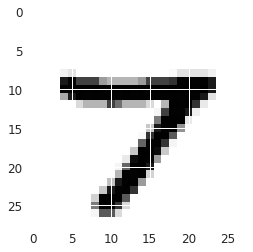

In [153]:
#training or testing

training=False
if( not training):
  num,dim=mnist.train.images.shape
  index=np.random.randint(num)
  image=mnist.train.images[index]
  image=image.reshape(-1,28,28)
  plt.imshow(image[0])
  print("Label is {0}".format(mnist.train.labels[index]))

In [154]:
from pathlib import Path

my_file = Path("./my_model_RNN_latest.ckpt.meta")

n_epochs = 100
batch_size = 150
saver = tf.train.Saver()

acc_summary = tf.summary.scalar('Accuracy', accuracy)

file_writer = tf.summary.FileWriter("./model_reuse/RNN", tf.get_default_graph())

with tf.Session() as sess:
    init.run()
    #restore file
    if my_file.is_file():
        saver.restore(sess, "./my_model_RNN_latest.ckpt")
        print("Loaded model from {0}".format(my_file.absolute))
    else:
        print("Failed to load file {0}".format(my_file.absolute))
    if(training):
        training_identifier_RNN(sess,n_epochs,saver)
    else:
        mylogit,myoutput,mystate=sess.run([logits,outputs, states], feed_dict={X: image})
        print(np.argmax(mylogit,axis=1))

INFO:tensorflow:Restoring parameters from ./my_model_RNN_latest.ckpt
Loaded model from <bound method Path.absolute of PosixPath('my_model_RNN_latest.ckpt.meta')>
[7]


In [155]:
np.shape(mystate)

(1, 150)

In [156]:
np.shape(myoutput)

(1, 28, 150)

# Prepare Data

In [157]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)
from IPython.core.debugger import set_trace
def next_batch(batch_size, n_steps,projectStep=1,DEBUG=False):
    if DEBUG:
      set_trace()
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + projectStep) * resolution
    ys = time_series(Ts)
    return ys[:, :-1 * projectStep].reshape(-1, n_steps, 1), ys[:, projectStep:].reshape(-1, n_steps, 1)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


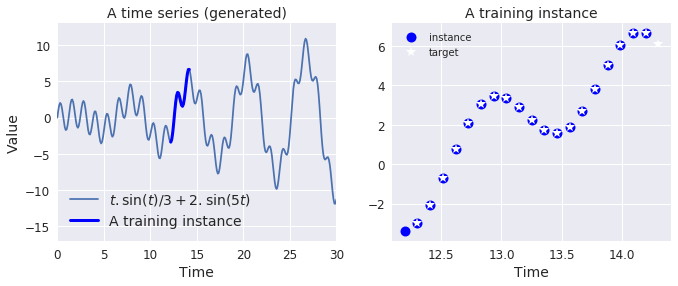

In [158]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

In [159]:
t_instance

array([12.2  , 12.305, 12.41 , 12.515, 12.62 , 12.725, 12.83 , 12.935,
       13.04 , 13.145, 13.25 , 13.355, 13.46 , 13.565, 13.67 , 13.775,
       13.88 , 13.985, 14.09 , 14.195, 14.3  ])

In [160]:
t_instance[1:]

array([12.305, 12.41 , 12.515, 12.62 , 12.725, 12.83 , 12.935, 13.04 ,
       13.145, 13.25 , 13.355, 13.46 , 13.565, 13.67 , 13.775, 13.88 ,
       13.985, 14.09 , 14.195, 14.3  ])

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


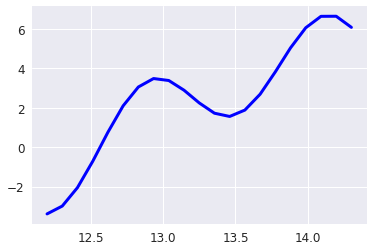

In [161]:
plt.plot(t_instance, time_series(t_instance), "b-", linewidth=3, label="A training instance")

In [162]:
seq1,seq2 = next_batch(5,3) # 5 instance , each step is 3
n_steps = 20
X_batch, y_batch = next_batch(1, n_steps) 

In [163]:
np.shape( np.c_[X_batch[0], y_batch[0]] )

(20, 2)

# Time series prediction: Using an OuputProjectionWrapper
Let's create the RNN. It will contain 100 recurrent neurons and we will unroll it over 20 time steps since each traiing instance will be 20 inputs long. Each input will contain only one feature (the value at that time). The targets are also sequences of 20 inputs, each containing a sigle value:

In [164]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

At each time step we now have an output vector of size 100. But what we actually want is a single output value at each time step. The simplest solution is to wrap the cell in an `OutputProjectionWrapper`.

In [191]:
reset_graph()

n_steps = 20*2
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

with tf.name_scope("rnn"):
  cell = tf.contrib.rnn.OutputProjectionWrapper(
      tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
      output_size=n_outputs)
  outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
  
  learning_rate = 0.001
with tf.name_scope("loss"):
  loss = tf.reduce_mean(tf.square(outputs - y)) # MSE

with tf.name_scope("training"):
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [192]:
def trainingTimeSeries(init,training_op,loss,batch_size,n_iterations,n_steps,prjStep):
  saver = tf.train.Saver()
  
  file_writer = tf.summary.FileWriter("./model_reuse/RNN_time_series", tf.get_default_graph())
  mse_summary=tf.summary.scalar('mse', loss)
  with tf.Session() as sess:
      init.run()
      for iteration in range(n_iterations):
          X_batch, y_batch = next_batch(batch_size, n_steps,prjStep)
          sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
          
          if iteration % 100 == 0:
              saver.save(sess, "./my_time_series_model{0}".format(iteration)) # not shown in the book
              mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
              print(iteration, "\tMSE:", mse)
              saver.save(sess, "./my_time_series_model_latest") # not shown in the book
          else:
              mse_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
              file_writer.add_summary(mse_str, iteration)
      saver.save(sess, "./my_time_series_model_latest") # not shown in the book

In [199]:
n_iterations = 1500
batch_size = 50
projectStep=1
Training=False

t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + projectStep), n_steps + projectStep)

if(Training):
  trainingTimeSeries(init,training_op,loss,batch_size,n_iterations,n_steps, projectStep)
else:
  with tf.Session() as sess:                          # not shown in the book
    saver.restore(sess, "./my_time_series_model")   # not shown
    
    X_new = time_series(np.array(t_instance[:-1*projectStep].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model


In [168]:
#show_graph(tf.get_default_graph())

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


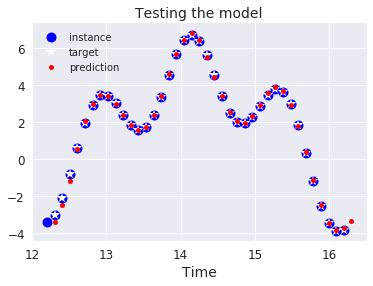

In [200]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1*projectStep], time_series(t_instance[:-1*projectStep]), "bo", markersize=10, label="instance")
plt.plot(t_instance[projectStep:], time_series(t_instance[projectStep:]), "w*", markersize=10, label="target")
plt.plot(t_instance[projectStep:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

In [195]:
np.shape(y_pred)

(1, 40, 1)

In [196]:
np.shape(t_instance)

(42,)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


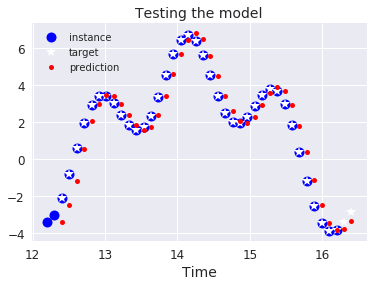

In [197]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1*projectStep], time_series(t_instance[:-1*projectStep]), "bo", markersize=10, label="instance")
plt.plot(t_instance[projectStep:], time_series(t_instance[projectStep:]), "w*", markersize=10, label="target")
plt.plot(t_instance[projectStep:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

In [171]:
t_instance[:-1 * 2]

array([12.2  , 12.305, 12.41 , 12.515, 12.62 , 12.725, 12.83 , 12.935,
       13.04 , 13.145, 13.25 , 13.355, 13.46 , 13.565, 13.67 , 13.775,
       13.88 , 13.985, 14.09 ])

In [172]:
next_batch(50, 20,2)

(array([[[ 0.52244545],
         [ 1.39110215],
         [ 1.92756626],
         [ 2.00348718],
         [ 1.60467087],
         [ 0.83446454],
         [-0.11166454],
         [-0.99413044],
         [-1.58805544],
         [-1.73851708],
         [-1.39868593],
         [-0.64151357],
         [ 0.35789437],
         [ 1.36490811],
         [ 2.1425729 ],
         [ 2.50937733],
         [ 2.38345077],
         [ 1.80237301],
         [ 0.91374981],
         [-0.06113433]],
 
        [[10.09550765],
         [ 9.03179276],
         [ 7.78700841],
         [ 6.60495745],
         [ 5.69383321],
         [ 5.17591566],
         [ 5.05850504],
         [ 5.23320193],
         [ 5.50370066],
         [ 5.63528   ],
         [ 5.4138607 ],
         [ 4.70015571],
         [ 3.46563869],
         [ 1.80150638],
         [-0.10157856],
         [-1.99802507],
         [-3.6452482 ],
         [-4.86083835],
         [-5.56499024],
         [-5.79782631]],
 
        [[ 2.41414113],
         [